# Creating VIIRS composites from the LEN repository

In [225]:
import sys, os, datetime
import geojson, imageio

import pandas as pd
import geopandas as gpd
import GOSTRocks.rasterMisc as rMisc

from GOSTRocks.misc import tPrint
from shapely.geometry import shape, Point

sys.path.append("../src")

import len_tools 
from len_tools import Catalog
from len_tools import VIIRS_cleaner

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [375]:
aws_bucket = 'globalnightlight'
iso3 = 'UKR'
out_folder = "/home/wb411133/temp/UKR/"
if not os.path.exists(out_folder):
    os.makedirs(out_folder)

adm0 = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
adm0 = adm0.loc[adm0.iso_a3 == iso3]

adm1 = gpd.read_file('/home/wb411133/data/Projects/UKR_Damage/Data/Admin/OCHA/ukr_admbnda_adm1_sspe_20220114.shp')

In [40]:
cat = Catalog()

In [171]:
start_day = "2022-01-01"
end_day = "2022-03-14"
# Generate catalog of images for country and time period
current_cat = cat.search_by_period(start_day, end_day)
current_cat = current_cat.search_by_intersect(adm0, calc_overlap=True)
current_cat.scenes = current_cat.scenes.sort_values(['datetime'])

/home/wb411133/.conda/envs/ee/lib/python3.9/site-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


In [172]:
# Throw away scenes with coverage lower than 25%
sel_scenes = current_cat.scenes.loc[current_cat.scenes.overlap > 0.25]

In [173]:
cleaner = VIIRS_cleaner(aws_bucket, sel_scenes, adm0.unary_union.buffer(2))
res = cleaner.clean_viirs_data(attach_numpy=True)

16:19:19	VIIRS_DNB_rade9_npp_202201: 0 of 273
16:19:32	VIIRS_DNB_rade9_npp_202201: 1 of 273
16:19:38	VIIRS_DNB_rade9_npp_202201: 2 of 273
16:19:47	VIIRS_DNB_rade9_npp_202201: 3 of 273
16:19:52	VIIRS_DNB_rade9_npp_202201: 4 of 273
16:20:07	VIIRS_DNB_rade9_npp_202201: 5 of 273
16:20:19	VIIRS_DNB_rade9_npp_202201: 6 of 273
16:20:26	VIIRS_DNB_rade9_npp_202201: 7 of 273
16:20:32	VIIRS_DNB_rade9_npp_202201: 8 of 273
16:20:39	VIIRS_DNB_rade9_npp_202201: 9 of 273
16:20:49	VIIRS_DNB_rade9_npp_202201: 10 of 273
16:20:58	VIIRS_DNB_rade9_npp_202201: 11 of 273
16:21:05	VIIRS_DNB_rade9_npp_202201: 12 of 273
16:21:15	VIIRS_DNB_rade9_npp_202201: 13 of 273
16:21:27	VIIRS_DNB_rade9_npp_202201: 14 of 273
16:21:40	VIIRS_DNB_rade9_npp_202201: 15 of 273
16:21:52	VIIRS_DNB_rade9_npp_202201: 16 of 273
16:22:02	VIIRS_DNB_rade9_npp_202201: 17 of 273
16:22:09	VIIRS_DNB_rade9_npp_202201: 18 of 273
16:22:20	VIIRS_DNB_rade9_npp_202201: 19 of 273
16:22:28	VIIRS_DNB_rade9_npp_202201: 20 of 273
16:22:35	VIIRS_DNB_rade

16:46:15	VIIRS_DNB_rade9_npp_202202: 173 of 273
16:46:22	VIIRS_DNB_rade9_npp_202202: 174 of 273
16:46:33	VIIRS_DNB_rade9_npp_202202: 175 of 273
16:46:44	VIIRS_DNB_rade9_npp_202202: 176 of 273
16:46:55	VIIRS_DNB_rade9_npp_202202: 177 of 273
16:47:07	VIIRS_DNB_rade9_npp_202202: 178 of 273
16:47:14	VIIRS_DNB_rade9_npp_202202: 179 of 273
16:47:20	VIIRS_DNB_rade9_npp_202202: 180 of 273
16:47:31	VIIRS_DNB_rade9_npp_202202: 181 of 273
16:47:41	VIIRS_DNB_rade9_npp_202202: 182 of 273
16:47:48	VIIRS_DNB_rade9_npp_202202: 183 of 273
16:47:57	VIIRS_DNB_rade9_npp_202202: 184 of 273
16:48:04	VIIRS_DNB_rade9_npp_202202: 185 of 273
16:48:10	VIIRS_DNB_rade9_npp_202202: 186 of 273
16:48:22	VIIRS_DNB_rade9_npp_202202: 187 of 273
16:48:31	VIIRS_DNB_rade9_npp_202202: 188 of 273
16:48:42	VIIRS_DNB_rade9_npp_202202: 189 of 273
16:48:52	VIIRS_DNB_rade9_npp_202202: 190 of 273
16:48:58	VIIRS_DNB_rade9_npp_202202: 191 of 273
16:49:08	VIIRS_DNB_rade9_npp_202202: 192 of 273
16:49:14	VIIRS_DNB_rade9_npp_202202: 193

In [218]:
cleaner.write_output(out_folder, f'{iso3}_{start_day}_{end_day}')

../src/len_tools.py:261: RuntimeWarning: invalid value encountered in true_divide
  rad_array = np.divide(self.final_data, self.final_count)


In [180]:
shift_folder = os.path.join(out_folder, "SHIFTED")
if not os.path.exists(shift_folder):
    os.makedirs(shift_folder)
cleaner.write_output_shift(res['scenes'], shift_folder)

../src/len_tools.py:307: RuntimeWarning: invalid value encountered in true_divide
  finalRad = finalRad/finalCnt


17:54:36	completed: 20220101 - 20220129
17:55:00	completed: 20220108 - 20220205
17:55:23	completed: 20220115 - 20220212
17:55:46	completed: 20220122 - 20220219
17:56:08	completed: 20220129 - 20220226
17:56:29	completed: 20220205 - 20220305
17:56:50	completed: 20220212 - 20220312


In [217]:
scenes = cleaner.scenes.sort_values(['datetime'])
scenes['datetime'] = pd.to_datetime(scenes['date'])
min_date = scenes['datetime'].min()
max_date = scenes['datetime'].max()

cur_date = min_date

while cur_date < max_date:
    print(cur_date)
    cur_date = cur_date + pd.DateOffset(days=7)


2022-01-01 00:00:00
2022-01-08 00:00:00
2022-01-15 00:00:00
2022-01-22 00:00:00
2022-01-29 00:00:00
2022-02-05 00:00:00
2022-02-12 00:00:00
2022-02-19 00:00:00
2022-02-26 00:00:00
2022-03-05 00:00:00
2022-03-12 00:00:00


# Calculate VIIRS quality

In [373]:
# calculate the quality of the VIIRS data (vflag)
quality_res = {}
for idx, row in scenes.iterrows():
    cur_quality = res['scenes'][idx][1]    
    total_pixels = cur_quality.shape[0] * cur_quality.shape[0]
    good_pixels = cur_quality.sum()
    quality_res[datetime.datetime.strftime(row['date'], "%Y-%m-%d")] = (good_pixels/total_pixels)
quality_res

{'2022-01-01': 0.05174012103951584,
 '2022-01-02': 0.05831484514061944,
 '2022-01-03': 0.023431683873264508,
 '2022-01-04': 0.12733584905660378,
 '2022-01-05': 0.36967376290494836,
 '2022-01-06': 0.0,
 '2022-01-07': 0.181112566749733,
 '2022-01-08': 0.26413641865432536,
 '2022-01-09': 0.0,
 '2022-01-10': 0.0017438234247063012,
 '2022-01-11': 0.1688061231755073,
 '2022-01-12': 0.06389248843004627,
 '2022-01-13': 0.0,
 '2022-01-14': 0.0,
 '2022-01-15': 0.0,
 '2022-01-16': 0.0,
 '2022-01-17': 0.0,
 '2022-01-18': 0.0,
 '2022-01-19': 0.0,
 '2022-01-20': 0.0,
 '2022-01-21': 0.0,
 '2022-01-22': 0.0,
 '2022-01-23': 0.0,
 '2022-01-24': 0.0,
 '2022-01-25': 0.0,
 '2022-01-26': 0.0,
 '2022-01-27': 6.835172659309363e-05,
 '2022-01-28': 0.01824065503737985,
 '2022-01-29': 0.0,
 '2022-01-30': 0.07584449982200071,
 '2022-01-31': 0.12614795300818796,
 '2022-02-01': 0.05123047347810609,
 '2022-02-02': 0.007060163759344962,
 '2022-02-03': 0.08423638305446778,
 '2022-02-04': 0.0,
 '2022-02-05': 0.39552253

<AxesSubplot:ylabel='Fraction of pixels that are good'>

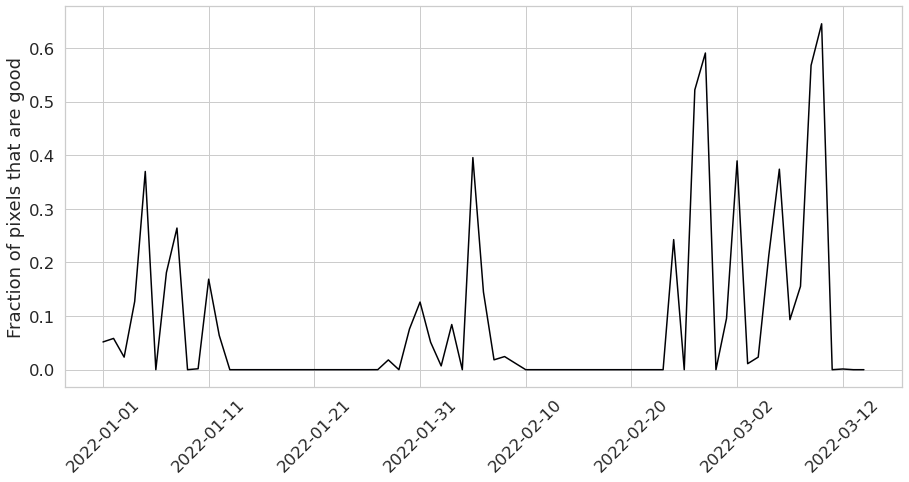

In [374]:
pd.DataFrame(quality_res, index=[0]).transpose().plot(
    figsize=(15,7), colormap='magma', legend=False, rot=45,
    ylabel = "Fraction of pixels that are good"


)

# Map VIIRS 

18:15:45	SHIFTED_20220101_20220129_rad.tif
18:15:46	SHIFTED_20220108_20220205_rad.tif
18:15:48	SHIFTED_20220115_20220212_rad.tif
18:15:49	SHIFTED_20220122_20220219_rad.tif
18:15:51	SHIFTED_20220129_20220226_rad.tif
18:15:53	SHIFTED_20220205_20220305_rad.tif
18:15:54	SHIFTED_20220212_20220312_rad.tif


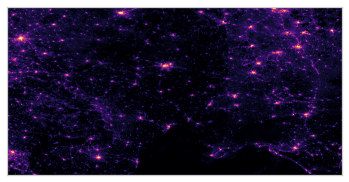

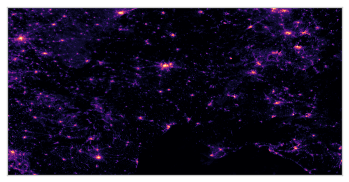

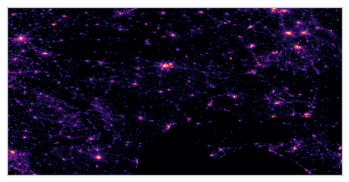

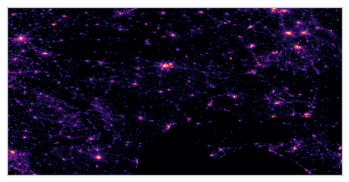

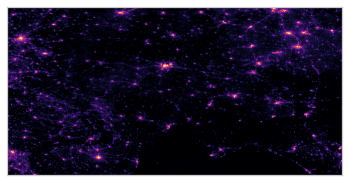

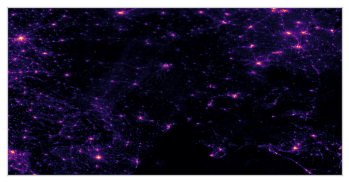

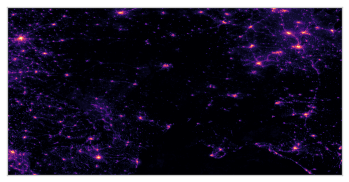

In [206]:
import sys, os, inspect, logging, json
import rasterio, boto3

import pandas as pd
import geopandas as gpd
import numpy as np
import xarray as xr
import rioxarray as rxr


# Generate animation of change in nighttime lights
def map_viirs(cur_file, out_file='', class_bins = [-10,0.5,1,2,3,5,10,15,20,30,40,50], text_x=0, text_y=5, dpi=300):
    ''' create map of viirs data
    
    INPUT
        cur_file [string] - path to input geotif
        [optional] out_file [string] - path to create output image
        [optional] class_bins [list numbers] - breaks for applying colour ramp
        [optional] text_x [int] - position on map to position year text (left to right)
        [optional] text_y [int] - position on map to position year text (top to bottom)
    '''
    # extract the year from the file name
    year = cur_file.split("_")[2]
    
    # Open the VIIRS data and reclassify 
    inR = rasterio.open(cur_file)
    inD = inR.read() 
    inD[np.isnan(inD)] = 0
    inC = xr.apply_ufunc(np.digitize,inD,class_bins)

    # Plot the figure, remove grid and ticks
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])
    
    ### TODO: add the year to the map, may need to experiment with the location depend on geography
    # ax.text(text_x, text_y, year, fontsize=40, color='white')

    #plt.margins(0,0)
    if out_file != '':
        #plt.imsave(out_file, inC[0,:,:], cmap=plt.get_cmap('magma'))
        plt.imshow(inC[0,:,:], cmap=plt.get_cmap('magma'))
        fig.savefig(out_file, dpi=dpi, bbox_inches='tight', pad_inches=0)
    else:
        # https://matplotlib.org/stable/tutorials/colors/colormaps.html
        plt.imshow(inC[0,:,:], cmap=plt.get_cmap('magma'))
    
maps_folder = os.path.join(out_folder, "SHIFTED_MAPS")

for in_file in os.listdir(shift_folder):
    if in_file.endswith("_rad.tif"):
        xx = map_viirs(os.path.join(shift_folder, in_file), os.path.join(maps_folder, in_file))        
        tPrint(in_file)
        

In [215]:
kwargs = {'duration':0.4}
images = []
all_tifs = [os.path.join(maps_folder, x) for x in os.listdir(maps_folder) if x.endswith(".tif")]
all_tifs.sort()

images.append(imageio.imread(all_tifs[0]))
images.append(imageio.imread(all_tifs[0]))
for filename in all_tifs:
    images.append(imageio.imread(filename))
#append the final image 3 times
images.append(imageio.imread(all_tifs[-1]))
images.append(imageio.imread(all_tifs[-1]))
images.append(imageio.imread(all_tifs[-1]))


imageio.mimsave(os.path.join(maps_folder, f'ANIMATION_{start_day}_{end_day}.gif'), images, **kwargs)

# Generate difference images

In [223]:
all_tifs = [os.path.join(shift_folder, x) for x in os.listdir(shift_folder) if x.endswith("rad.tif")]

inR0 = rasterio.open(all_tifs[0])
inR1 = rasterio.open(all_tifs[-1])

inR0_data = inR0.read()
inR1_data = inR1.read()

diff_data = inR1_data - inR0_data

out_file = os.path.join(out_folder, "VIIRS_change.tif")

with rasterio.open(out_file, 'w', **inR0.meta) as out_raster:
    out_raster.write(diff_data)

# Summarize NTL in ADM1

In [383]:
ntl_res = adm1.loc[:,['ADM1_EN','ADM1_PCODE']]

for cur_tif in all_tifs:
    res = rMisc.zonalStats(adm1, cur_tif, minVal=1)
    tif_date = cur_tif.split("_")[-3]
    res = pd.DataFrame(res, columns = ['SUM', 'MIN', 'MAX', 'MEAN'])
    ntl_res[f'NTL_{tif_date}'] = res['SUM']
    tPrint(cur_tif)

09:06:00	/home/wb411133/temp/UKR/SHIFTED/SHIFTED_20220101_20220129_rad.tif
09:06:01	/home/wb411133/temp/UKR/SHIFTED/SHIFTED_20220108_20220205_rad.tif
09:06:02	/home/wb411133/temp/UKR/SHIFTED/SHIFTED_20220115_20220212_rad.tif
09:06:03	/home/wb411133/temp/UKR/SHIFTED/SHIFTED_20220122_20220219_rad.tif
09:06:04	/home/wb411133/temp/UKR/SHIFTED/SHIFTED_20220129_20220226_rad.tif
09:06:04	/home/wb411133/temp/UKR/SHIFTED/SHIFTED_20220205_20220305_rad.tif
09:06:05	/home/wb411133/temp/UKR/SHIFTED/SHIFTED_20220212_20220312_rad.tif


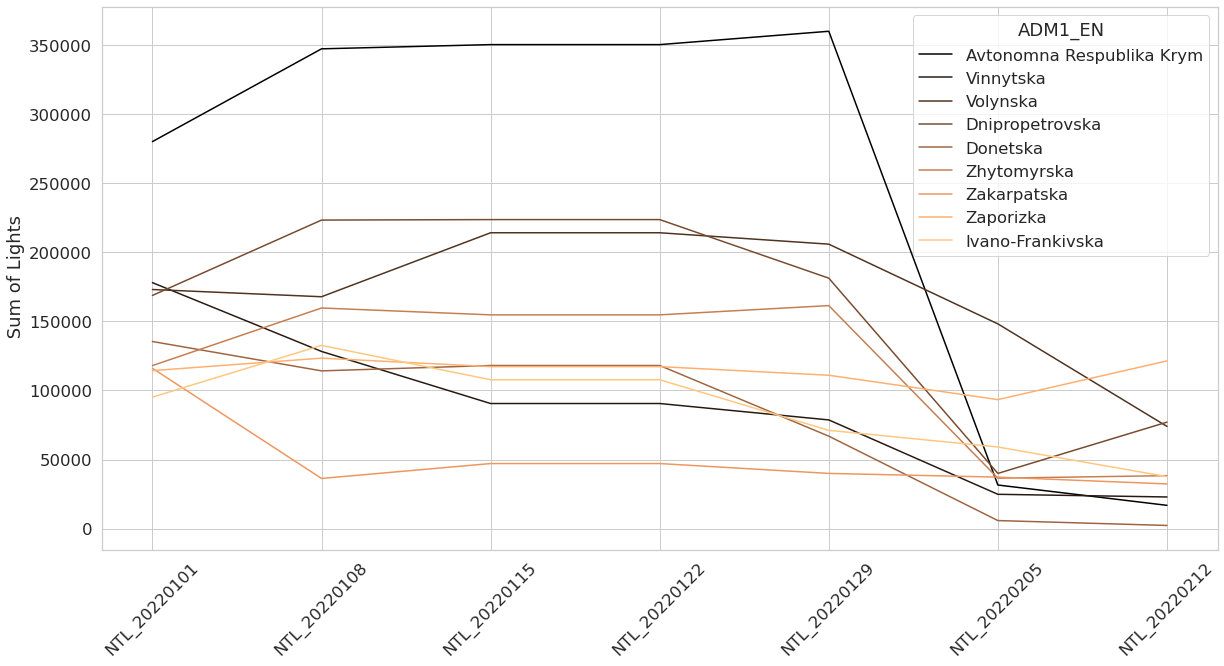

In [414]:
ntl_res = ntl_res.sort_values('NTL_20220101', ascending=False)
ntl_plot = ntl_res.drop(['ADM1_PCODE', 'ADM1_EN'], axis=1).transpose()
ntl_plot.columns = adm1['ADM1_EN']
def map_ntl(map_data):
    pd.DataFrame(map_data).plot(
        figsize=(20,10), colormap='copper', legend=True, rot=45, 
        ylabel=' Sum of Lights'
    )

map_ntl(ntl_plot.iloc[:,0:9])

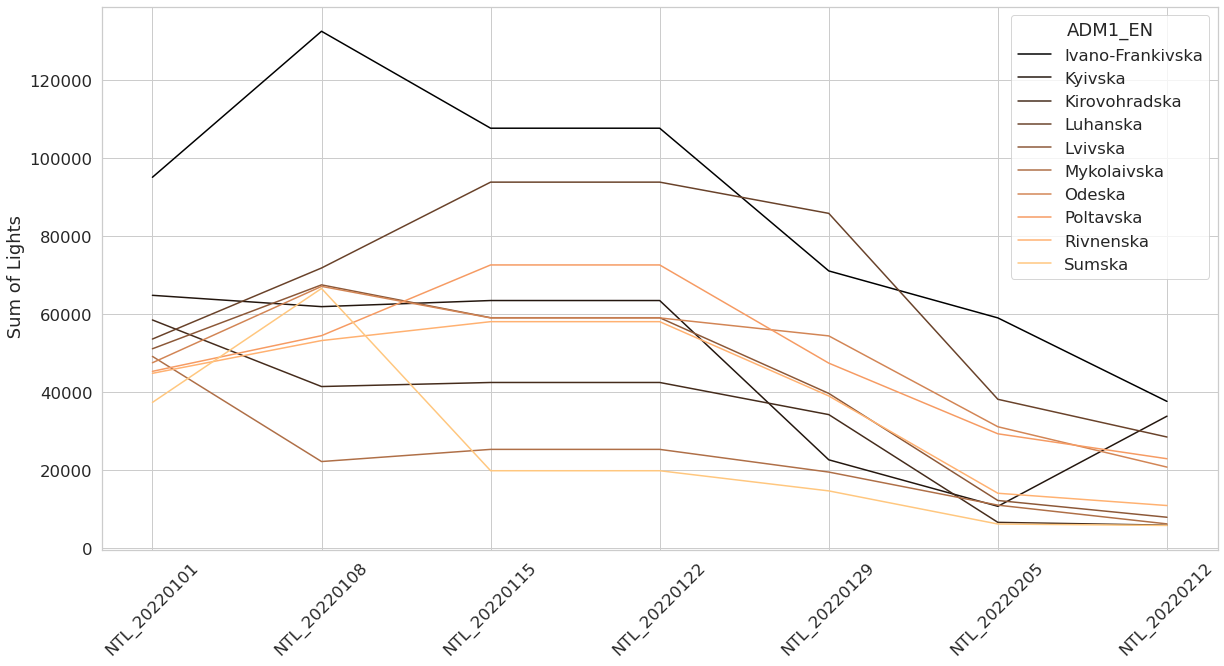

In [415]:
map_ntl(ntl_plot.iloc[:,8:18])

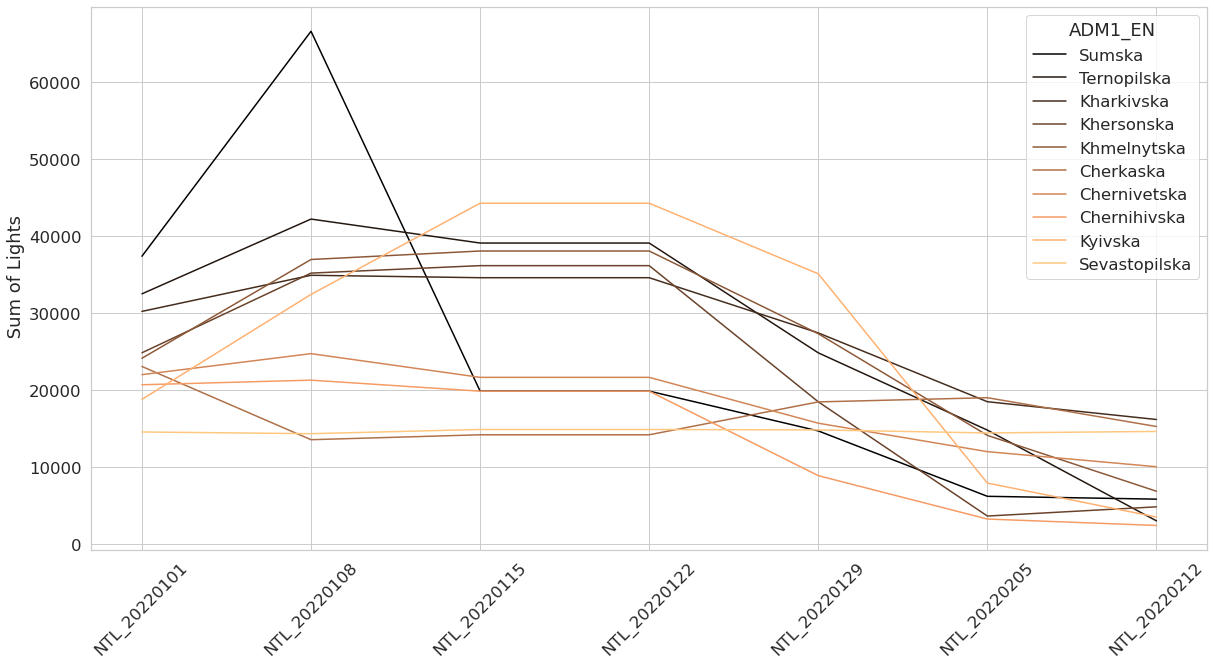

In [416]:
map_ntl(ntl_plot.iloc[:,17:])

# Summarize population in VIIRS images

In [269]:
pop_layer = "/home/wb411133/data/Projects/UKR_Damage/Data/ukr_ppp_2020_UNadj_constrained.tif"
pop_s = pop_layer.replace(".tif", "_standardized.tif")
inPop = rasterio.open(pop_layer)

In [270]:
all_tifs = [os.path.join(shift_folder, x) for x in os.listdir(shift_folder) if x.endswith("rad.tif")]

inR0 = rasterio.open(all_tifs[0])
popD, pop_meta = rMisc.standardizeInputRasters(inPop, inR0)
class_bins = [-10,0.5,1,2,3,5,10,15,20,30,40,50]

In [289]:
cur_res = {}

for ntl_file in all_tifs:
    cur_date = ntl_file.split("_")[-3]
    inR = rasterio.open(ntl_file)
    ntlD = inR.read()    
    ntlC = xr.apply_ufunc(np.digitize, ntlD, class_bins)
    class_res = []
    for cur_class in np.unique(ntlC):
        cur_ntl = ntlC == cur_class
        cur_pop = popD * cur_ntl
        class_res.append(cur_pop.sum())
    cur_res[cur_date] = class_res
    tPrint(os.path.basename(ntl_file))

21:21:13	SHIFTED_20220101_20220129_rad.tif
21:21:14	SHIFTED_20220108_20220205_rad.tif
21:21:16	SHIFTED_20220115_20220212_rad.tif
21:21:17	SHIFTED_20220122_20220219_rad.tif
21:21:19	SHIFTED_20220129_20220226_rad.tif
21:21:20	SHIFTED_20220205_20220305_rad.tif
21:21:22	SHIFTED_20220212_20220312_rad.tif


In [325]:
ntl_res = pd.DataFrame(pd.DataFrame(cur_res).transpose())
ntl_res = ntl_res.drop(['20220101'])
ntl_res.columns = [f'NTL {x}' for x in ['< 0',0,1,2,3,5,10,15,20,30,40,50]]
ntl_res.head()

,NTL < 0,NTL 0,NTL 1,NTL 2,NTL 3,NTL 5,NTL 10,NTL 15,NTL 20,NTL 30,NTL 40,NTL 50
20220108,2127852.0,2894147.50,5732622.0,4291361.0,6057928.5,9106668.0,4966217.5,3074046.00,3396489.500,1.926047e+06,1.032988e+06,10493926.0
20220115,2283977.0,3177652.25,5727116.5,4731560.0,6497697.0,9421074.0,5043765.0,3089975.50,3257165.000,1.953254e+06,8.910259e+05,9026049.0
20220122,2283977.0,3177652.25,5727116.5,4731560.0,6497697.0,9421074.0,5043765.0,3089975.50,3257165.000,1.953254e+06,8.910259e+05,9026049.0
20220129,2595271.0,4571153.00,7136595.5,5478991.5,7063116.0,8763159.0,4395427.0,2690661.50,2811446.500,1.338929e+06,7.036369e+05,7551903.0
20220205,6004106.5,10237463.00,9448226.0,5299602.5,5994895.0,6255842.5,2573672.0,1255848.75,1223596.875,5.070542e+05,1.652540e+05,6134720.0


<AxesSubplot:>

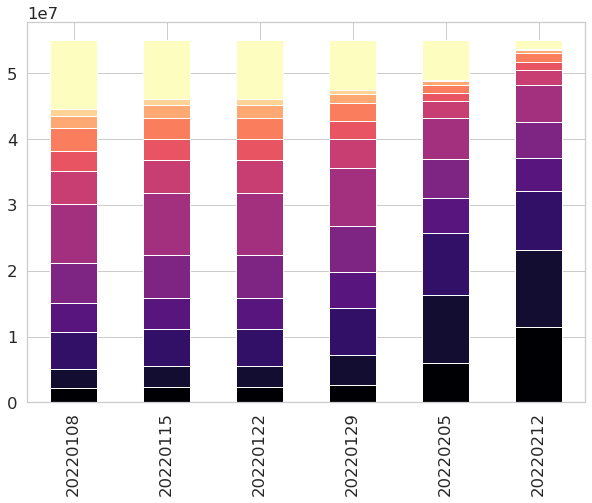

In [344]:
ntl_res.plot(kind='bar', stacked=True, figsize=(10,7), colormap='magma', legend=False)

In [337]:
# Summarize population in nighttime list change
changeR = rasterio.open(os.path.join(out_folder, "VIIRS_change.tif"))
changeD = changeR.read()

ntlT1 = rasterio.open(all_tifs[-1])
ntlT1D = ntlT1.read()

In [338]:
# What percent of the population has seen lights decrease
decreaseD = changeD < 0
decreasePop = decreaseD * popD
print(f'{round(decreasePop.sum())} people have seen light decrease, which is {round(decreasePop.sum()/popD.sum() * 100)}%')

46017992 people have seen light decrease, which is 84%


In [346]:
# What percent of the population has seen lights decrease by at least 50%
percent_change = changeD/ntlT1D
perD =  percent_change < -0.50
decreasePop = decreaseD * perD
print(f'{round(decreasePop.sum())} people have seen light decrease by {thresh}, which is {round(decreasePop.sum()/popD.sum() * 100)}%')

4180686 people have seen light decrease, which is 8%


In [345]:
popD.sum()

55100324.0

# Debugging